In [2]:
pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [4]:
# Assuming you've already loaded your data
df = pd.read_csv("/content/engine_data.csv")

In [6]:
# 1. Basic correlation analysis with the target variable
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation with target variable using Pearson correlation
target_correlations = df.corr()['Engine Condition'].sort_values(ascending=False)
print("Pearson Correlations with Engine Condition:")
print(target_correlations)



CORRELATION ANALYSIS
Pearson Correlations with Engine Condition:
Engine Condition    1.000000
Fuel pressure       0.116259
Lub oil pressure    0.060904
Coolant pressure   -0.024054
Coolant temp       -0.046326
lub oil temp       -0.093635
Engine rpm         -0.268201
Name: Engine Condition, dtype: float64


<ipython-input-7-427631ffc1cf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')


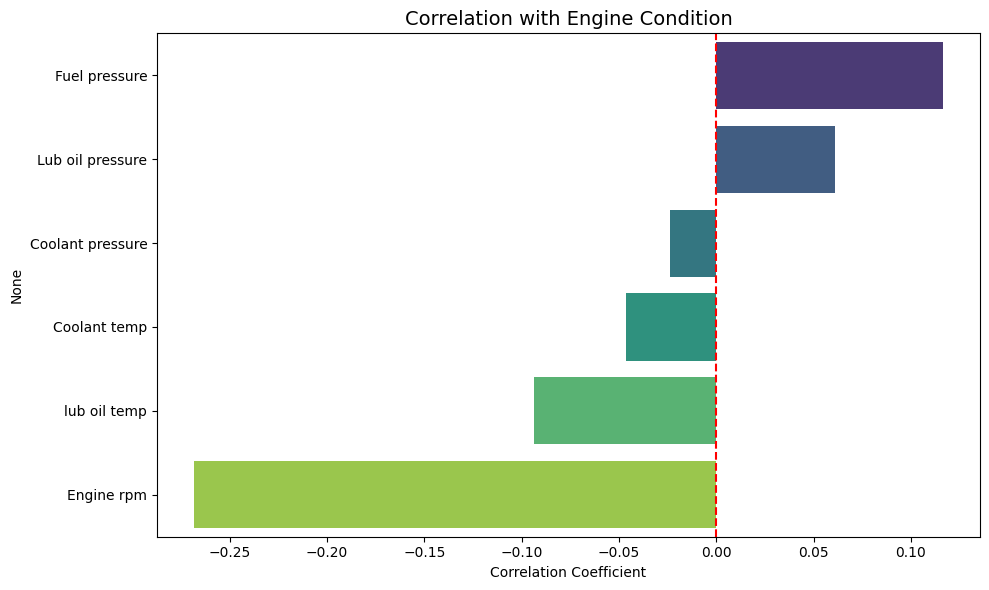

In [7]:
# Create a focused heatmap just for correlations with Engine Condition
plt.figure(figsize=(10, 6))
target_corr = target_correlations.drop('Engine Condition')  # Remove self-correlation
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Correlation with Engine Condition', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('correlation_with_target.png')
plt.show()

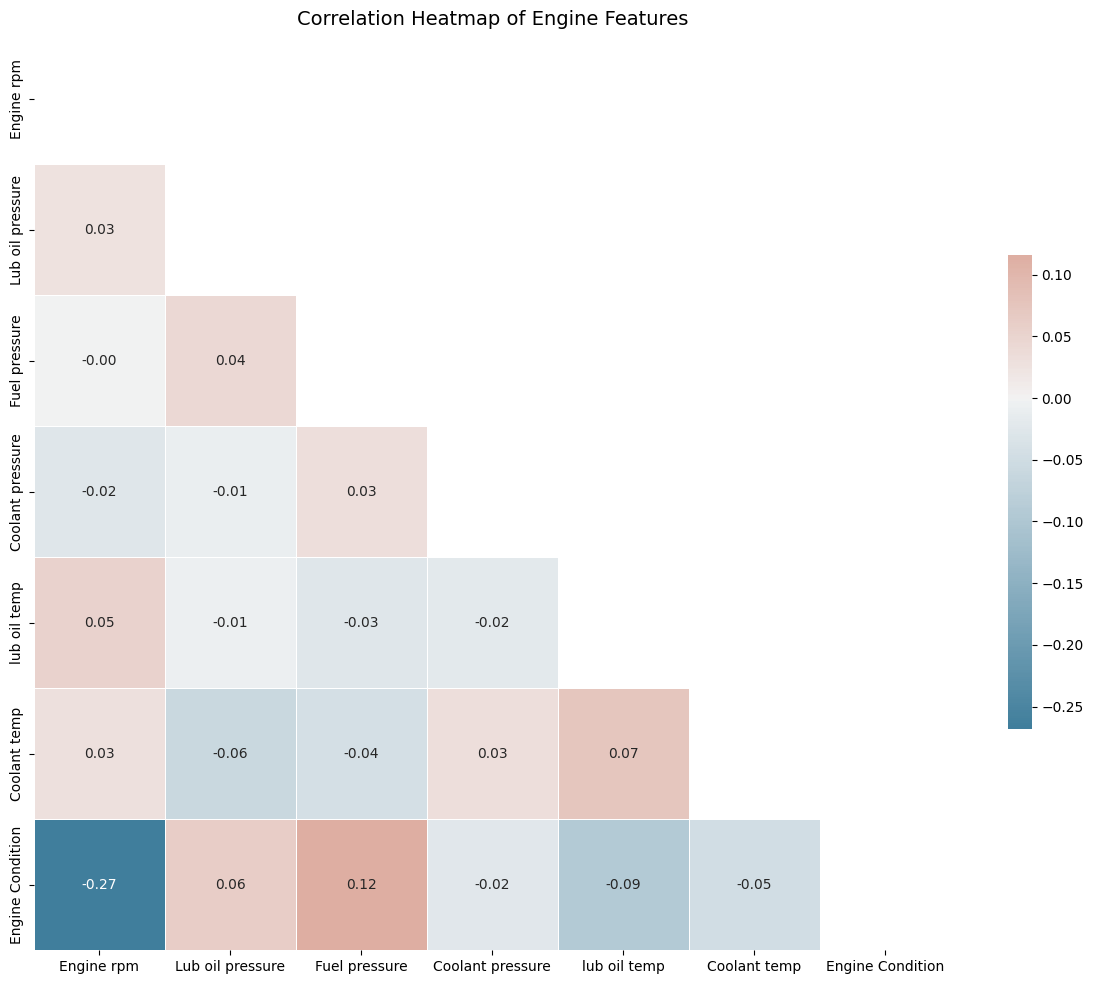

In [8]:
# 2. Complete correlation heatmap with better visualization
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix,
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Engine Features', fontsize=14)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()


POINT-BISERIAL CORRELATION
Point-Biserial Correlations with Engine Condition:
                  correlation        p_value
Engine rpm          -0.268201  4.970794e-319
Fuel pressure        0.116259   9.309532e-60
lub oil temp        -0.093635   2.695837e-39
Lub oil pressure     0.060904   1.599327e-17
Coolant temp        -0.046326   9.298446e-11
Coolant pressure    -0.024054   7.729357e-04


<ipython-input-12-80165e9fa613>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pb_correlations['correlation'], y=pb_correlations.index, palette='viridis')


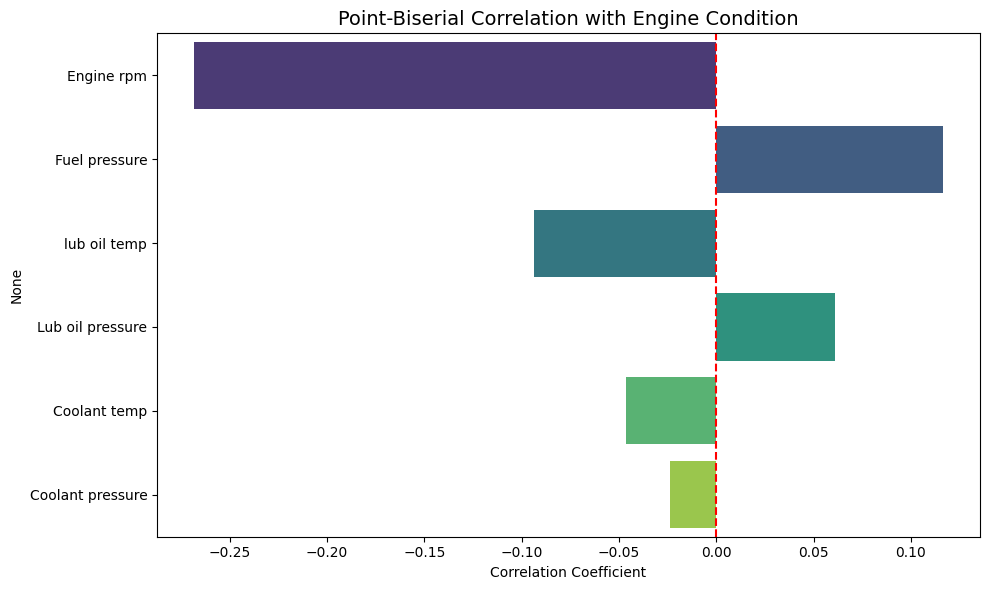

In [12]:
# 3. Point-biserial correlation for binary target
print("\n" + "="*80)
print("POINT-BISERIAL CORRELATION")
print("="*80)

from scipy.stats import pointbiserialr

# Calculate point-biserial correlation for each feature with the target
point_biserial_results = {}
for column in df.columns[:-1]:  # Exclude the target
    correlation, p_value = pointbiserialr(df[column], df['Engine Condition'])
    point_biserial_results[column] = {'correlation': correlation, 'p_value': p_value}

# Convert to DataFrame for easier viewing
pb_correlations = pd.DataFrame(point_biserial_results).T
pb_correlations = pb_correlations.sort_values('correlation', key=abs, ascending=False)
print("Point-Biserial Correlations with Engine Condition:")
print(pb_correlations)

# Visualize point-biserial correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_correlations['correlation'], y=pb_correlations.index, palette='viridis')
plt.title('Point-Biserial Correlation with Engine Condition', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.savefig('point_biserial_correlation.png')
plt.show()



STATISTICAL FEATURE SELECTION
Feature Selection using ANOVA F-value:
            Feature      F_Score        P_Value
0        Engine rpm  1513.946537  4.970844e-319
2     Fuel pressure   267.630004   9.309532e-60
4      lub oil temp   172.771652   2.695837e-39
1  Lub oil pressure    72.722611   1.599327e-17
5      Coolant temp    42.009867   9.298446e-11
3  Coolant pressure    11.308684   7.729357e-04


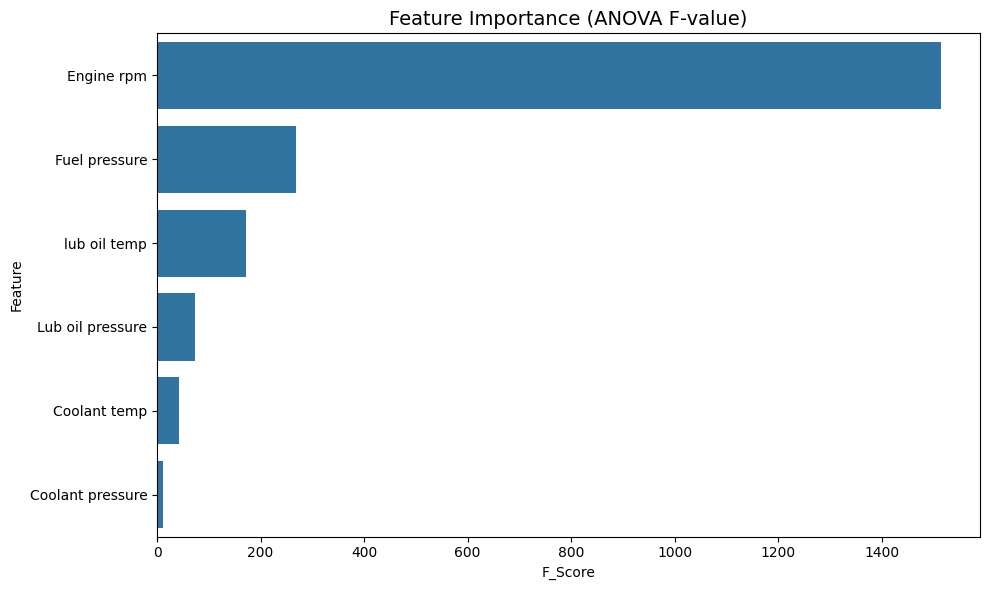


Feature Selection using Mutual Information:
            Feature  MI_Score
0        Engine rpm  0.045414
3  Coolant pressure  0.012893
2     Fuel pressure  0.010179
4      lub oil temp  0.006917
1  Lub oil pressure  0.001221
5      Coolant temp  0.000454


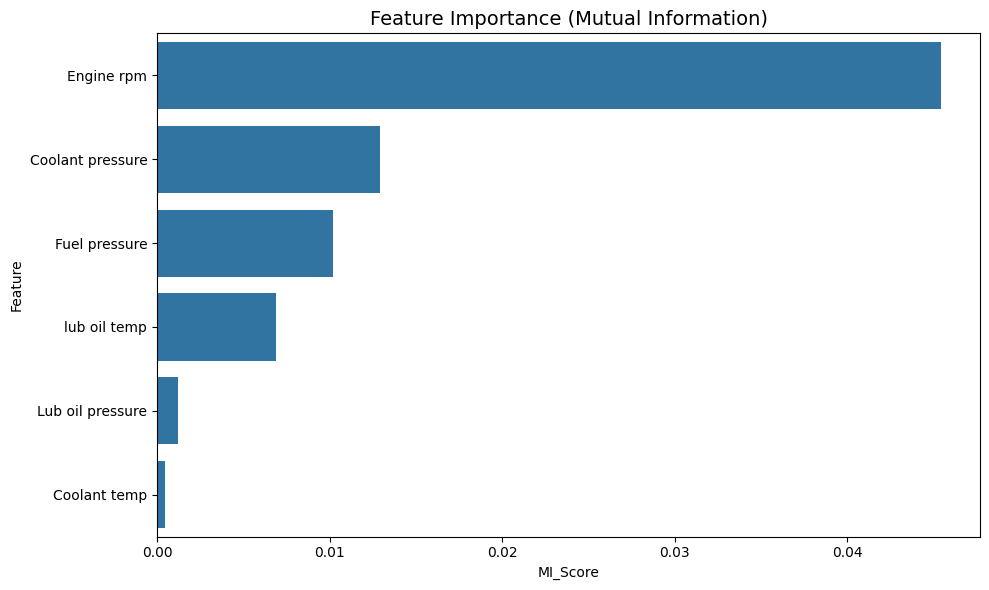

In [13]:
# 4. Statistical feature selection with SelectKBest
print("\n" + "="*80)
print("STATISTICAL FEATURE SELECTION")
print("="*80)

# Prepare the features and target (using original data, not PCA)
features = df.columns[:-1].tolist()
X = df[features]
y = df['Engine Condition']

# Using ANOVA F-value
print("Feature Selection using ANOVA F-value:")
selector_f = SelectKBest(f_classif, k='all')
selector_f.fit(X, y)
f_scores = pd.DataFrame({
    'Feature': features,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
})
f_scores = f_scores.sort_values('F_Score', ascending=False)
print(f_scores)

# Visualize F-scores
plt.figure(figsize=(10, 6))
sns.barplot(x='F_Score', y='Feature', data=f_scores)
plt.title('Feature Importance (ANOVA F-value)', fontsize=14)
plt.tight_layout()
plt.savefig('f_scores.png')
plt.show()

# Using Mutual Information
print("\nFeature Selection using Mutual Information:")
selector_mi = SelectKBest(mutual_info_classif, k='all')
selector_mi.fit(X, y)
mi_scores = pd.DataFrame({
    'Feature': features,
    'MI_Score': selector_mi.scores_
})
mi_scores = mi_scores.sort_values('MI_Score', ascending=False)
print(mi_scores)

# Visualize MI scores
plt.figure(figsize=(10, 6))
sns.barplot(x='MI_Score', y='Feature', data=mi_scores)
plt.title('Feature Importance (Mutual Information)', fontsize=14)
plt.tight_layout()
plt.savefig('mi_scores.png')
plt.show()



MODEL-BASED FEATURE SELECTION
Random Forest Feature Importance:
            Feature  Importance
0        Engine rpm    0.221475
2     Fuel pressure    0.165967
4      lub oil temp    0.159504
1  Lub oil pressure    0.154738
3  Coolant pressure    0.150103
5      Coolant temp    0.148212


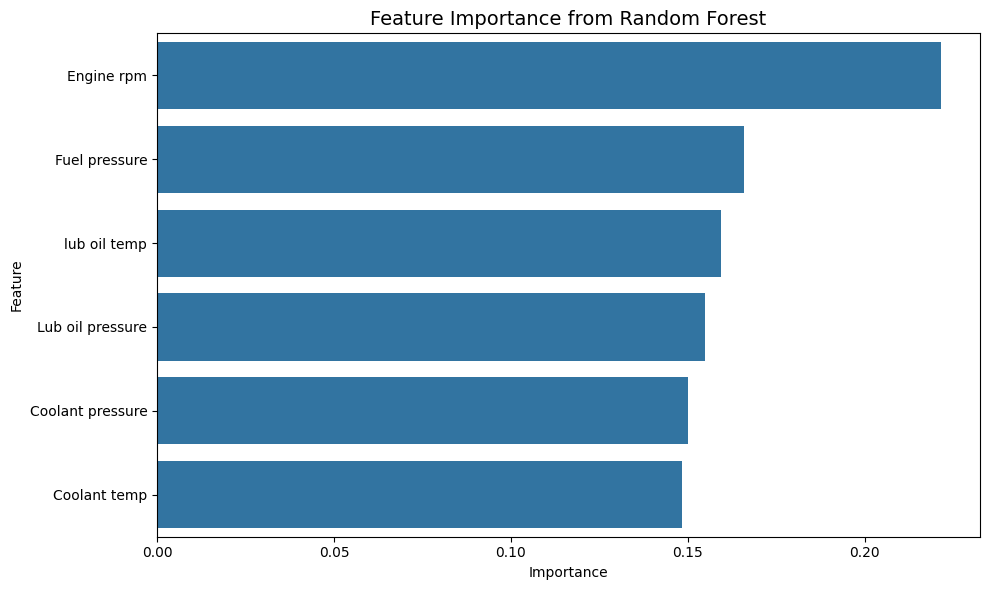


XGBoost Feature Importance:
            Feature  Importance
0        Engine rpm    0.410055
2     Fuel pressure    0.156804
4      lub oil temp    0.119832
1  Lub oil pressure    0.114248
5      Coolant temp    0.101872
3  Coolant pressure    0.097190


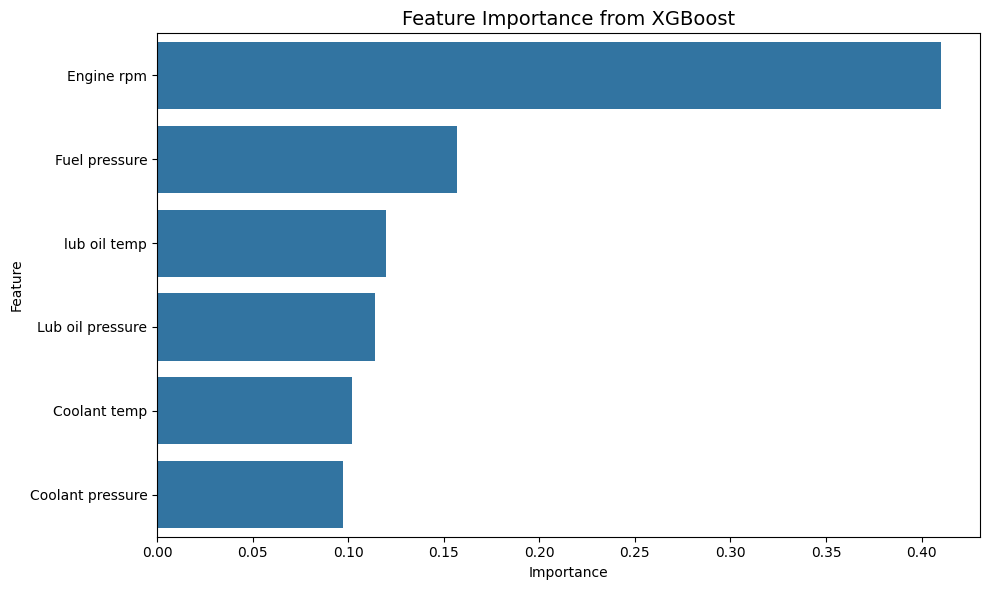


RECURSIVE FEATURE ELIMINATION
RFE Feature Selection Results:
            Feature  Selected  Ranking
0        Engine rpm      True        1
2     Fuel pressure      True        1
4      lub oil temp      True        1
1  Lub oil pressure     False        2
3  Coolant pressure     False        3
5      Coolant temp     False        4


In [14]:
# 5. Model-based feature selection
print("\n" + "="*80)
print("MODEL-BASED FEATURE SELECTION")
print("="*80)

# Random Forest Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)
print("Random Forest Feature Importance:")
print(rf_importance)

# Visualize RF importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance)
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.tight_layout()
plt.savefig('rf_importance.png')
plt.show()

# XGBoost Feature Importance
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)
xgb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)
print("\nXGBoost Feature Importance:")
print(xgb_importance)

# Visualize XGBoost importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance)
plt.title('Feature Importance from XGBoost', fontsize=14)
plt.tight_layout()
plt.savefig('xgb_importance.png')
plt.show()

# 6. Recursive Feature Elimination (RFE)
print("\n" + "="*80)
print("RECURSIVE FEATURE ELIMINATION")
print("="*80)

# Use Random Forest as the base estimator for RFE
rfe_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=len(features)//2, step=1)
rfe.fit(X, y)

# Get RFE results
rfe_results = pd.DataFrame({
    'Feature': features,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
})
rfe_results = rfe_results.sort_values('Ranking')
print("RFE Feature Selection Results:")
print(rfe_results)


In [15]:
# 6. Recursive Feature Elimination (RFE)
print("\n" + "="*80)
print("RECURSIVE FEATURE ELIMINATION")
print("="*80)

# Use Random Forest as the base estimator for RFE
rfe_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rfe_model, n_features_to_select=len(features)//2, step=1)
rfe.fit(X, y)

# Get RFE results
rfe_results = pd.DataFrame({
    'Feature': features,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
})
rfe_results = rfe_results.sort_values('Ranking')
print("RFE Feature Selection Results:")
print(rfe_results)



RECURSIVE FEATURE ELIMINATION
RFE Feature Selection Results:
            Feature  Selected  Ranking
0        Engine rpm      True        1
2     Fuel pressure      True        1
4      lub oil temp      True        1
1  Lub oil pressure     False        2
3  Coolant pressure     False        3
5      Coolant temp     False        4



PERMUTATION IMPORTANCE
Permutation Importance:
            feature    weight       std
0        Engine rpm  0.301664  0.002292
1     Fuel pressure  0.203686  0.001148
2      lub oil temp  0.187530  0.002332
3  Lub oil pressure  0.149117  0.002122
4      Coolant temp  0.096238  0.001664
5  Coolant pressure  0.087218  0.000882


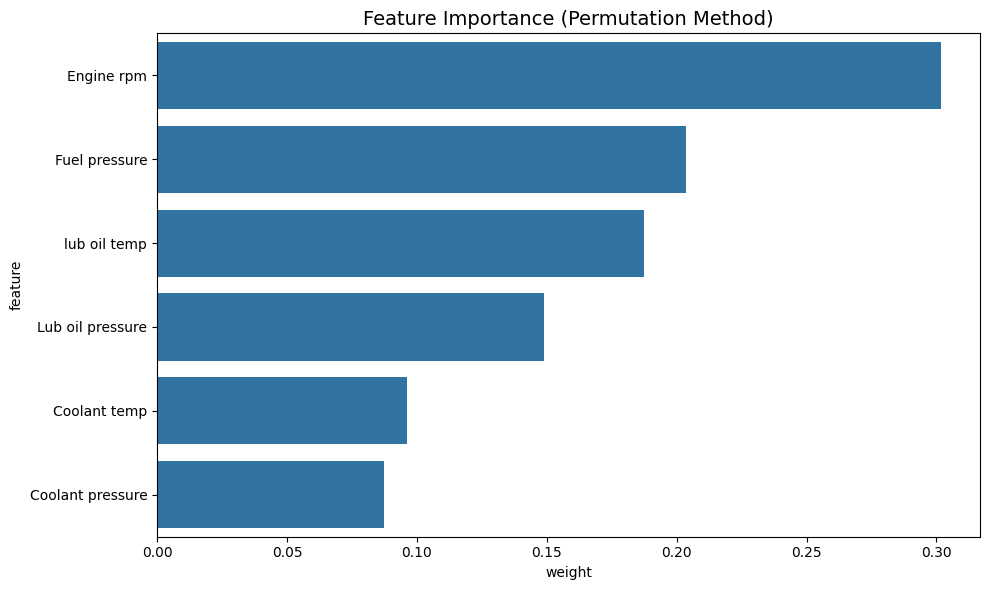

In [16]:
# 7. Permutation Importance (more reliable than standard importance)
print("\n" + "="*80)
print("PERMUTATION IMPORTANCE")
print("="*80)

# Train a model first (using Random Forest)
rf_perm = RandomForestClassifier(n_estimators=100, random_state=42)
rf_perm.fit(X, y)

# Calculate permutation importance
perm = PermutationImportance(rf_perm, random_state=42).fit(X, y)
perm_importance = eli5.explain_weights_df(perm, feature_names=features)
perm_importance = perm_importance.sort_values('weight', ascending=False)
print("Permutation Importance:")
print(perm_importance)

# Visualize permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x='weight', y='feature', data=perm_importance)
plt.title('Feature Importance (Permutation Method)', fontsize=14)
plt.tight_layout()
plt.savefig('permutation_importance.png')
plt.show()


FEATURE SELECTION VALIDATION
Combined Feature Ranking:
                  Correlation   F_Score  MI_Score  RF_Importance  \
Engine rpm           1.000000  1.000000  1.000000       1.000000   
Fuel pressure        0.433478  0.176776  0.224143       0.749370   
lub oil temp         0.349123  0.114120  0.152314       0.720189   
Lub oil pressure     0.227082  0.048035  0.026880       0.698671   
Coolant pressure     0.089688  0.007470  0.283897       0.677743   
Coolant temp         0.172728  0.027749  0.010003       0.669201   

                  XGB_Importance  RFE_Rank  Permutation  Average_Rank  
Engine rpm              1.000000  1.000000     1.000000      1.000000  
Fuel pressure           0.382398  1.000000     0.675208      0.520196  
lub oil temp            0.292234  1.000000     0.621653      0.464233  
Lub oil pressure        0.278618  0.666667     0.494315      0.348610  
Coolant pressure        0.237017  0.333333     0.289123      0.274039  
Coolant temp            0.248435  0

<ipython-input-17-e0898204f6bf>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_ranks['Average_Rank'], y=feature_ranks.index, palette='viridis')


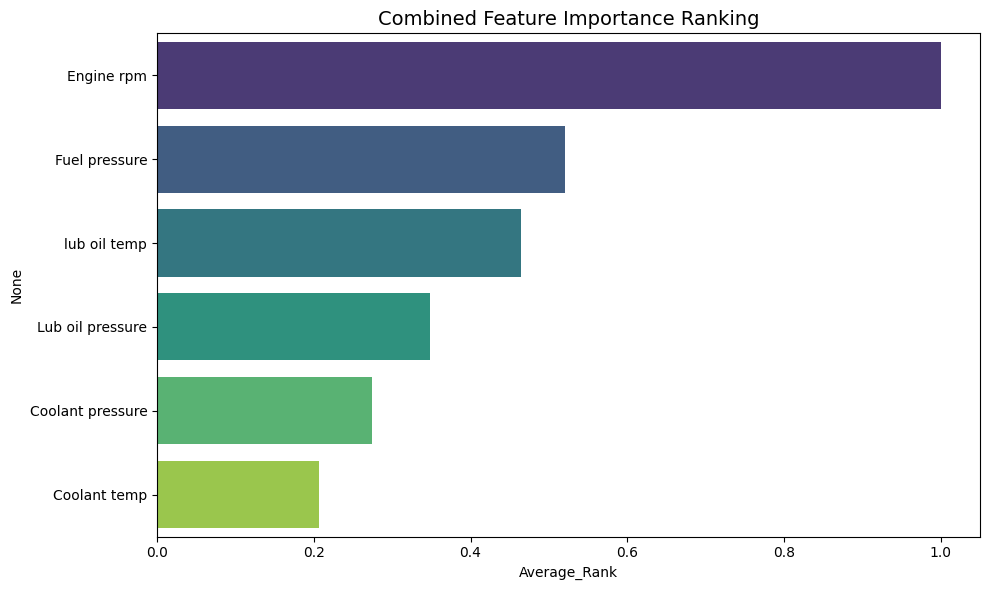

In [17]:
# 8. Feature Selection Validation
print("\n" + "="*80)
print("FEATURE SELECTION VALIDATION")
print("="*80)

# Combine all feature selection methods to get a consensus
feature_ranks = pd.DataFrame(index=features)
feature_ranks['Correlation'] = [abs(target_correlations.get(f, 0)) for f in features]
feature_ranks['F_Score'] = [f_scores[f_scores['Feature'] == f]['F_Score'].values[0] if f in f_scores['Feature'].values else 0 for f in features]
feature_ranks['MI_Score'] = [mi_scores[mi_scores['Feature'] == f]['MI_Score'].values[0] if f in mi_scores['Feature'].values else 0 for f in features]
feature_ranks['RF_Importance'] = [rf_importance[rf_importance['Feature'] == f]['Importance'].values[0] if f in rf_importance['Feature'].values else 0 for f in features]
feature_ranks['XGB_Importance'] = [xgb_importance[xgb_importance['Feature'] == f]['Importance'].values[0] if f in xgb_importance['Feature'].values else 0 for f in features]
feature_ranks['RFE_Rank'] = [rfe_results[rfe_results['Feature'] == f]['Ranking'].values[0] if f in rfe_results['Feature'].values else 0 for f in features]
feature_ranks['Permutation'] = [perm_importance[perm_importance['feature'] == f]['weight'].values[0] if f in perm_importance['feature'].values else 0 for f in features]

# Normalize all scores to 0-1 range for fair comparison
for col in feature_ranks.columns:
    if col != 'RFE_Rank':  # We want lower RFE ranks, higher values for others
        if feature_ranks[col].max() != 0:
            feature_ranks[col] = feature_ranks[col] / feature_ranks[col].max()
    else:
        if feature_ranks[col].max() != 0:
            feature_ranks[col] = 1 - ((feature_ranks[col] - 1) / (feature_ranks[col].max() - 1))

# Calculate the average ranking across all methods
feature_ranks['Average_Rank'] = feature_ranks.mean(axis=1)
feature_ranks = feature_ranks.sort_values('Average_Rank', ascending=False)
print("Combined Feature Ranking:")
print(feature_ranks)

# Create a final visualization of the combined ranking
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_ranks['Average_Rank'], y=feature_ranks.index, palette='viridis')
plt.title('Combined Feature Importance Ranking', fontsize=14)
plt.tight_layout()
plt.savefig('combined_feature_ranking.png')
plt.show()



MODEL PERFORMANCE WITH FEATURE SUBSETS
Model Performance with Different Feature Subsets:
   n_features                                           features  \
0           1                                         Engine rpm   
1           2                          Engine rpm, Fuel pressure   
2           3            Engine rpm, Fuel pressure, lub oil temp   
3           5  Engine rpm, Fuel pressure, lub oil temp, Lub o...   
4           7  Engine rpm, Fuel pressure, lub oil temp, Lub o...   
5           6  Engine rpm, Fuel pressure, lub oil temp, Lub o...   

   mean_accuracy  std_accuracy  
0       0.624622      0.004563  
1       0.608754      0.004321  
2       0.636499      0.004420  
3       0.648989      0.002731  
4       0.654671      0.005613  
5       0.654671      0.005613  


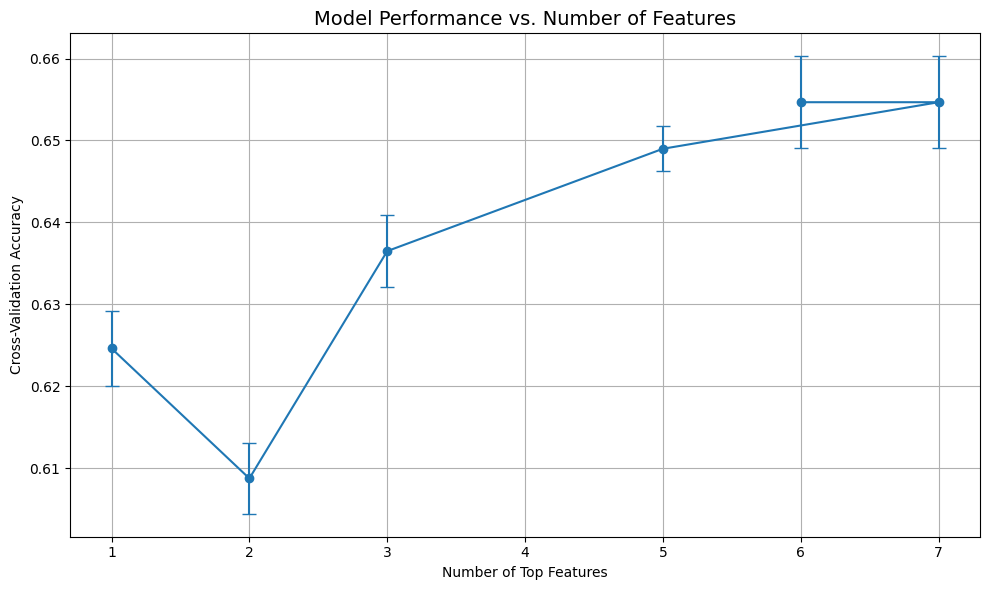

In [18]:
# 9. Model performance with different feature subsets
print("\n" + "="*80)
print("MODEL PERFORMANCE WITH FEATURE SUBSETS")
print("="*80)

# Test with different numbers of top features
top_features_list = [1, 2, 3, 5, 7, len(features)]
results = []

for n_features in top_features_list:
    # Select top n features
    selected_features = feature_ranks.index[:n_features].tolist()

    # Evaluate with Random Forest using cross-validation
    rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_cv, X[selected_features], y, cv=5, scoring='accuracy')

    results.append({
        'n_features': n_features,
        'features': ', '.join(selected_features),
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std()
    })

# Display results
results_df = pd.DataFrame(results)
print("Model Performance with Different Feature Subsets:")
print(results_df)

# Visualize model performance with different feature counts
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['n_features'], results_df['mean_accuracy'],
             yerr=results_df['std_accuracy'], fmt='o-', capsize=5)
plt.xlabel('Number of Top Features')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Performance vs. Number of Features', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('feature_count_performance.png')
plt.show()


FEATURE DISTRIBUTIONS BY ENGINE CONDITION


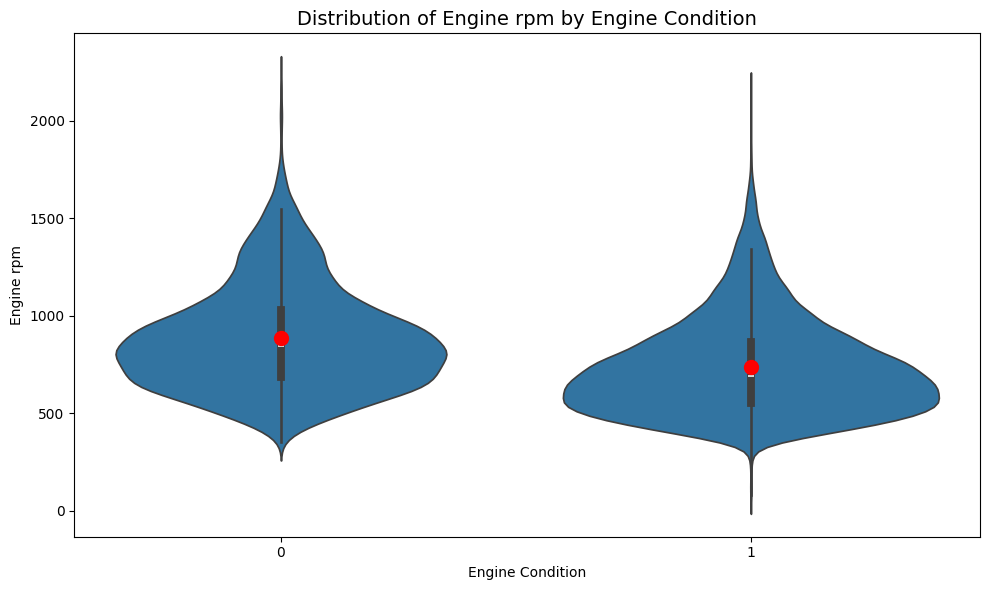


Statistics for Engine rpm by Engine Condition:
                    count        mean         std    min    25%    50%  \
Engine Condition                                                         
0                  7218.0  884.995012  271.722814  351.0  685.0  843.0   
1                 12317.0  736.296582  249.302159   61.0  552.0  690.0   

                     75%     max  
Engine Condition                  
0                 1031.0  2239.0  
1                  868.0  2172.0  


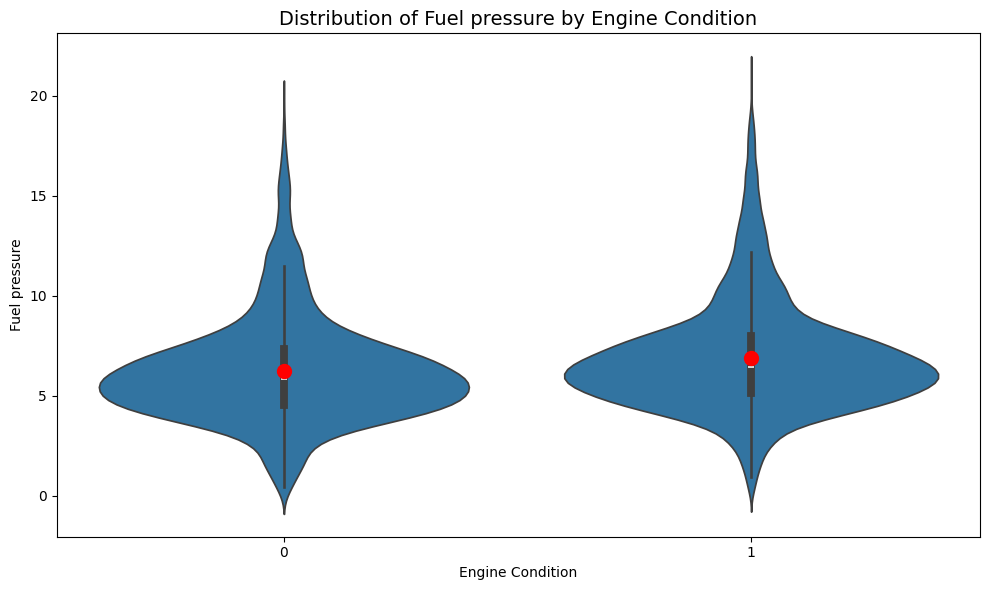


Statistics for Fuel pressure by Engine Condition:
                    count      mean       std       min       25%       50%  \
Engine Condition                                                              
0                  7218.0  6.236310  2.681545  0.003187  4.543139  5.824090   
1                 12317.0  6.901337  2.777391  0.050703  5.157232  6.420928   

                       75%        max  
Engine Condition                       
0                 7.319333  19.858917  
1                 7.969611  21.138326  


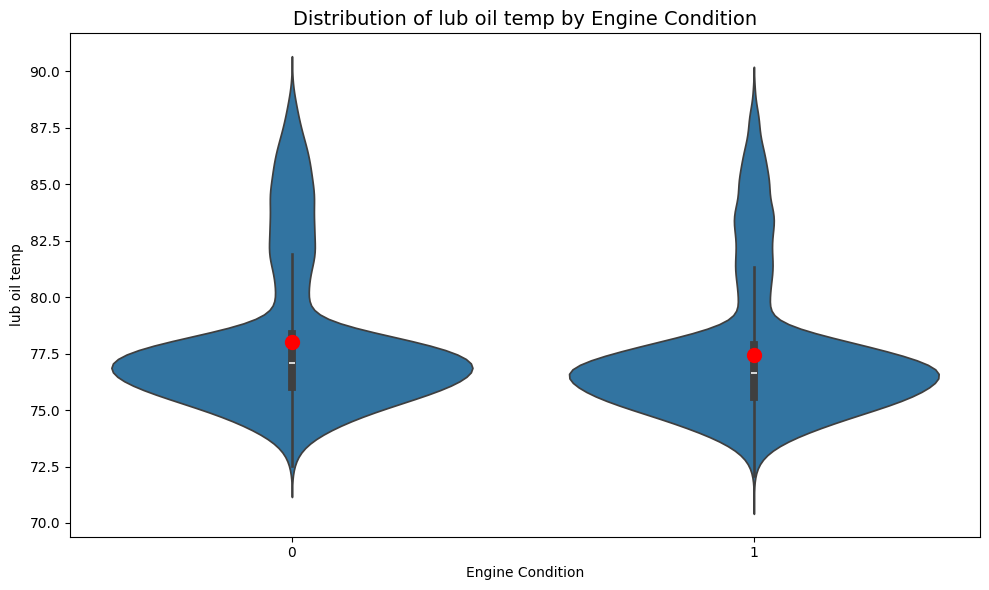


Statistics for lub oil temp by Engine Condition:
                    count       mean       std        min        25%  \
Engine Condition                                                       
0                  7218.0  78.023934  3.231807  72.244554  76.015079   
1                 12317.0  77.420432  3.015850  71.321974  75.572548   

                        50%        75%        max  
Engine Condition                                   
0                 77.089781  78.370924  89.580796  
1                 76.660067  77.890560  89.286302  


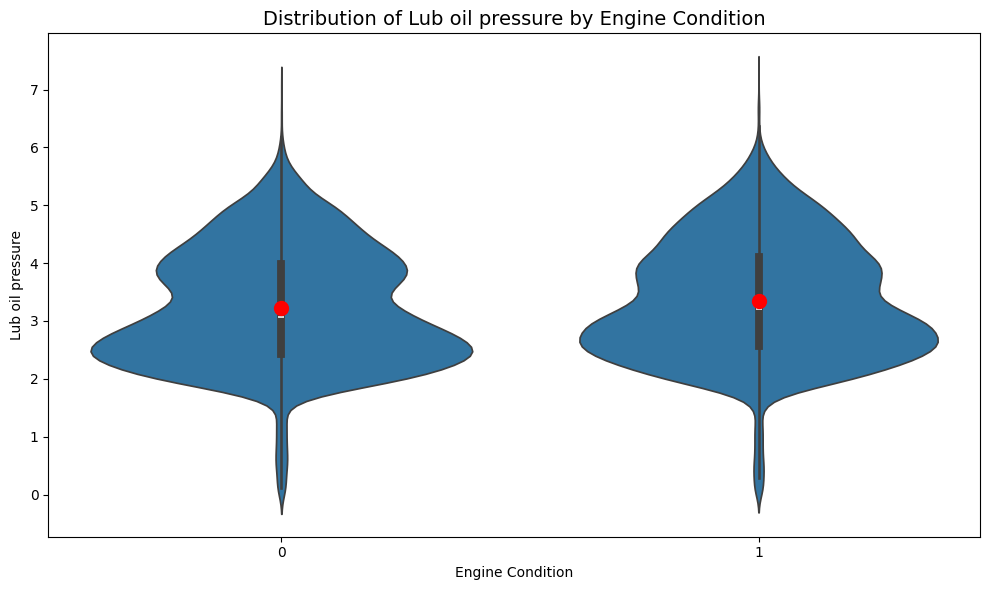


Statistics for Lub oil pressure by Engine Condition:
                    count      mean       std       min       25%       50%  \
Engine Condition                                                              
0                  7218.0  3.222497  1.010354  0.007891  2.433852  3.067195   
1                 12317.0  3.351406  1.025252  0.003384  2.572670  3.214466   

                       75%       max  
Engine Condition                      
0                 3.986081  7.051322  
1                 4.103583  7.265566  


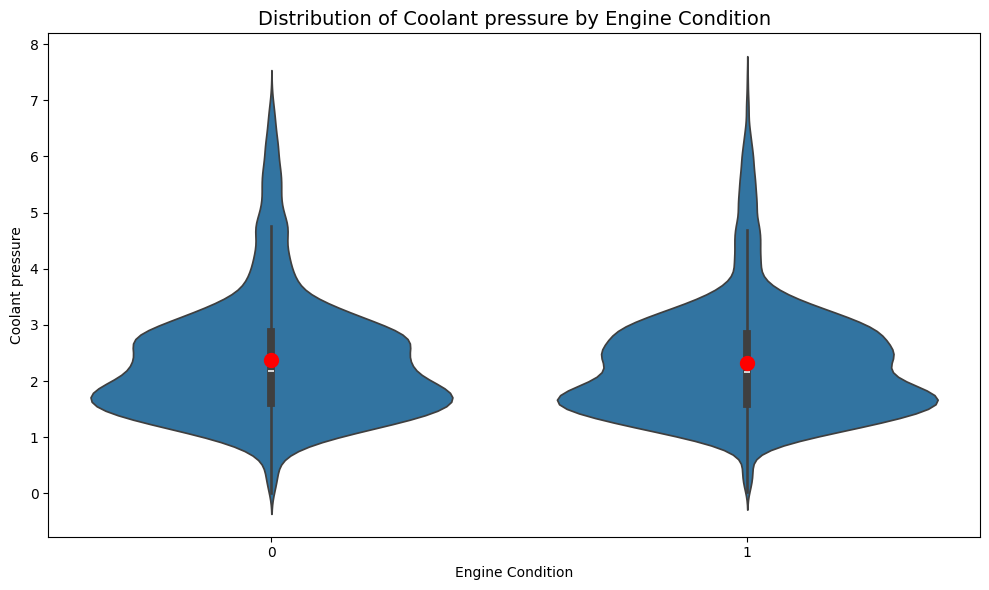


Statistics for Coolant pressure by Engine Condition:
                    count      mean       std       min       25%       50%  \
Engine Condition                                                              
0                  7218.0  2.367934  1.087158  0.002483  1.607461  2.181739   
1                 12317.0  2.316285  1.004990  0.015665  1.594980  2.158007   

                       75%       max  
Engine Condition                      
0                 2.866988  7.168410  
1                 2.838314  7.478505  


In [19]:
# 10. Distribution of values for each feature by target class
print("\n" + "="*80)
print("FEATURE DISTRIBUTIONS BY ENGINE CONDITION")
print("="*80)

# Plot distribution of top features by engine condition
top_n = 5  # Show distributions for top 5 features
for feature in feature_ranks.index[:top_n]:
    plt.figure(figsize=(10, 6))

    # Create violin plots
    sns.violinplot(x='Engine Condition', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Engine Condition', fontsize=14)

    # Add means as points
    means = df.groupby('Engine Condition')[feature].mean()
    plt.plot([0, 1], means, 'ro', ms=10)

    plt.tight_layout()
    plt.savefig(f'distribution_{feature}.png')
    plt.show()

    # Show basic statistics
    print(f"\nStatistics for {feature} by Engine Condition:")
    print(df.groupby('Engine Condition')[feature].describe())

In [22]:
# Complete ML Model Pipeline with Feature Selection, Training, and Evaluation

# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # Added XGBoost
from sklearn.pipeline import Pipeline

In [23]:
# 2. Split data into training, validation, and testing sets
# Assuming X contains selected features and y contains the target variable
# X = df[selected_features]  # Selected features
# y = df['target']  # Target variable

# First split: 80% for training+validation and 20% for testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% of the remaining data for training and 25% for validation (resulting in 60% training, 20% validation, 20% testing)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Validation data size: {X_val.shape}")
print(f"Testing data size: {X_test.shape}")


Training data size: (11721, 6)
Validation data size: (3907, 6)
Testing data size: (3907, 6)


In [24]:

# 3. Data Preprocessing
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)




Training Logistic Regression model...
Logistic Regression model training accuracy: 0.6656
Logistic Regression model validation accuracy: 0.6637

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.31      0.41      1456
           1       0.68      0.87      0.76      2451

    accuracy                           0.66      3907
   macro avg       0.64      0.59      0.59      3907
weighted avg       0.65      0.66      0.63      3907



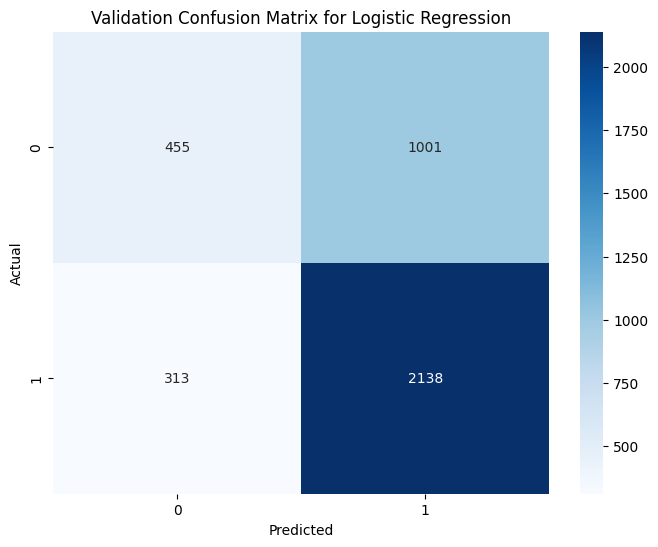


Training Decision Tree model...
Decision Tree model training accuracy: 1.0000
Decision Tree model validation accuracy: 0.6005

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.48      0.47      1456
           1       0.68      0.67      0.68      2451

    accuracy                           0.60      3907
   macro avg       0.57      0.58      0.57      3907
weighted avg       0.60      0.60      0.60      3907



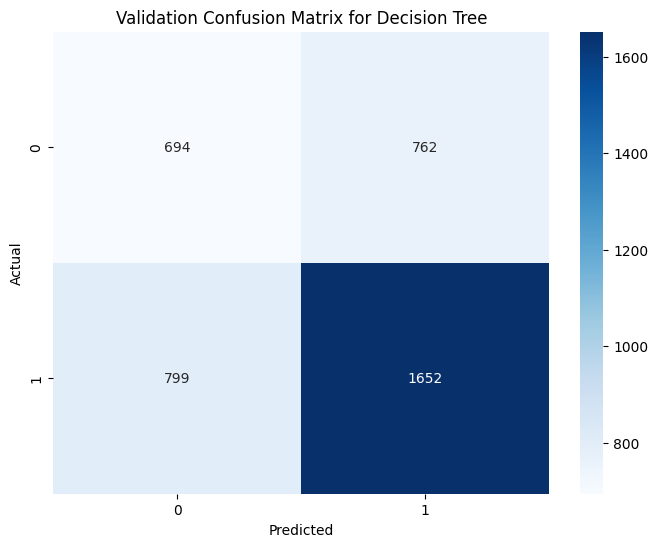


Training Random Forest model...
Random Forest model training accuracy: 1.0000
Random Forest model validation accuracy: 0.6598

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.41      0.48      1456
           1       0.70      0.81      0.75      2451

    accuracy                           0.66      3907
   macro avg       0.63      0.61      0.61      3907
weighted avg       0.65      0.66      0.65      3907



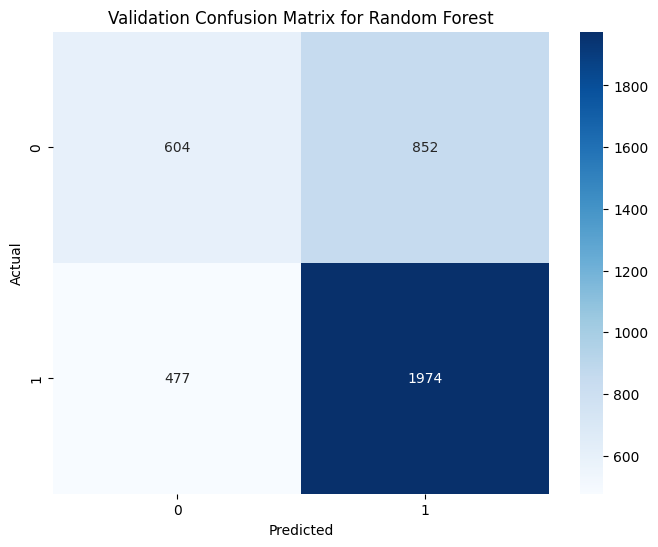


Training Gradient Boosting model...
Gradient Boosting model training accuracy: 0.7011
Gradient Boosting model validation accuracy: 0.6673

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.36      0.45      1456
           1       0.69      0.85      0.76      2451

    accuracy                           0.67      3907
   macro avg       0.64      0.61      0.61      3907
weighted avg       0.65      0.67      0.65      3907



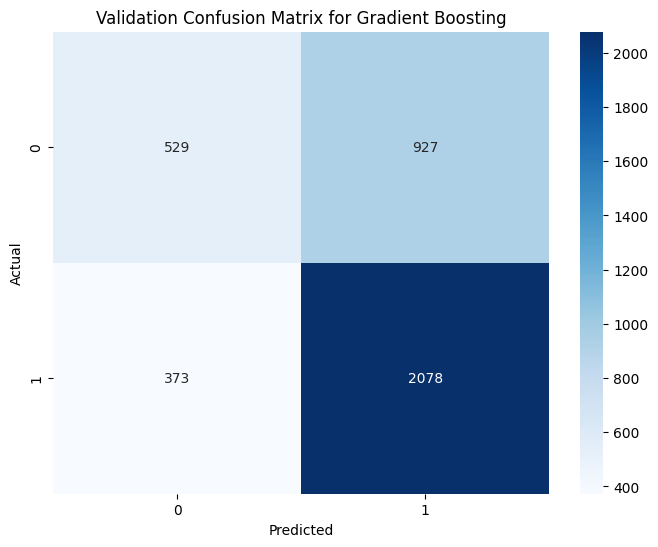


Training XGBoost model...
XGBoost model training accuracy: 0.8856
XGBoost model validation accuracy: 0.6532

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.40      0.46      1456
           1       0.69      0.80      0.74      2451

    accuracy                           0.65      3907
   macro avg       0.62      0.60      0.60      3907
weighted avg       0.64      0.65      0.64      3907



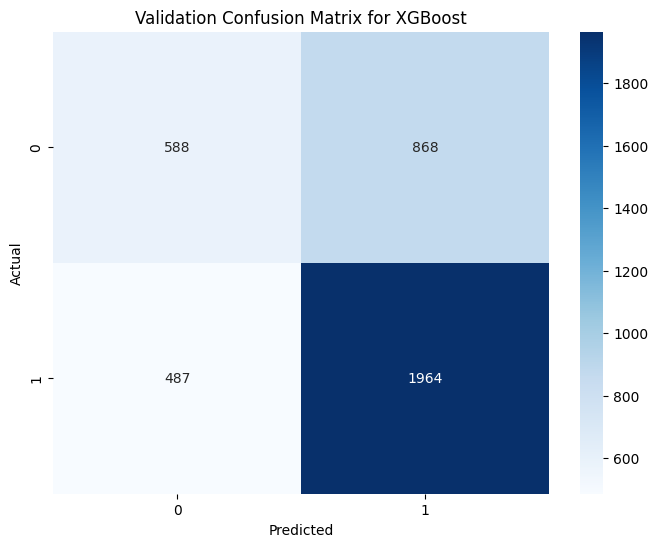


Training SVM model...
SVM model training accuracy: 0.6826
SVM model validation accuracy: 0.6642

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.29      0.39      1456
           1       0.68      0.89      0.77      2451

    accuracy                           0.66      3907
   macro avg       0.64      0.59      0.58      3907
weighted avg       0.65      0.66      0.63      3907



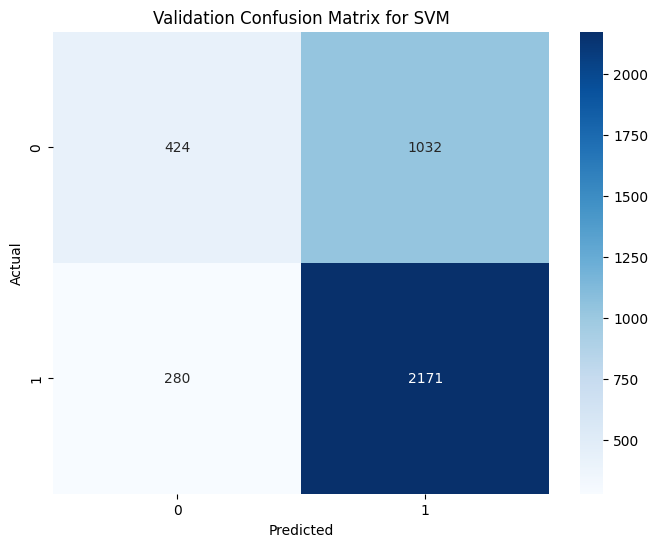


Training KNN model...
KNN model training accuracy: 0.7524
KNN model validation accuracy: 0.6278

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      1456
           1       0.68      0.76      0.72      2451

    accuracy                           0.63      3907
   macro avg       0.59      0.58      0.58      3907
weighted avg       0.62      0.63      0.62      3907



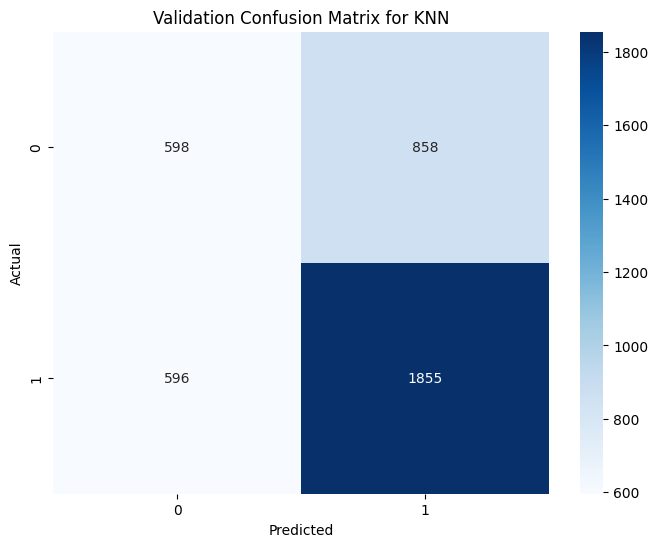

In [25]:

# 4. Build and test multiple models to choose the best one
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),  # Added XGBoost model
    "SVM": SVC(random_state=42, probability=True),
    "KNN": KNeighborsClassifier()
}

# Store train and validation accuracy results for each model
train_results = {}
val_results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name} model...")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on training data for sanity check
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_results[name] = train_accuracy

    # Predict on validation data to choose best model
    y_val_pred = model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_results[name] = val_accuracy

    print(f"{name} model training accuracy: {train_accuracy:.4f}")
    print(f"{name} model validation accuracy: {val_accuracy:.4f}")
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))

    # Plot confusion matrix for validation data
    plt.figure(figsize=(8, 6))
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Validation Confusion Matrix for {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()



<Figure size 1400x800 with 0 Axes>

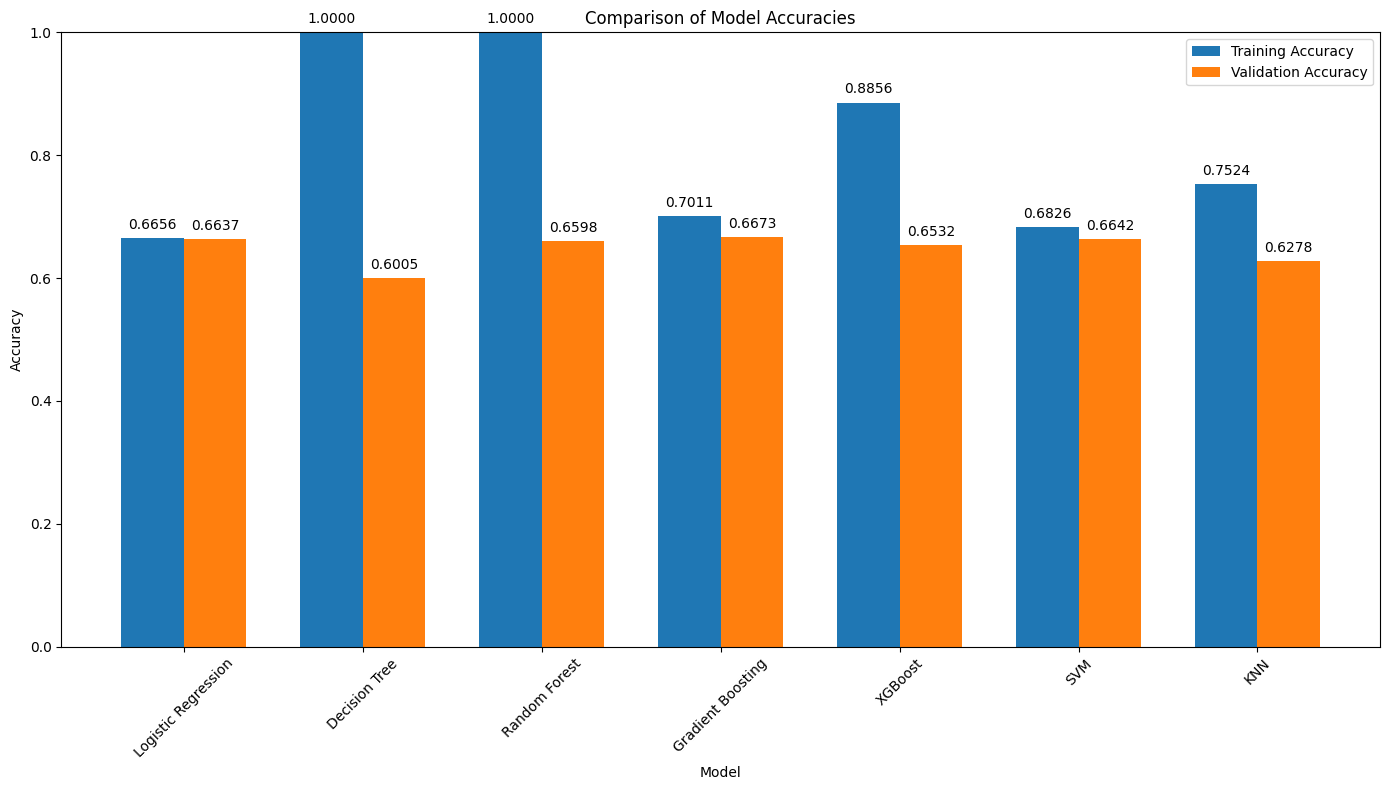

In [30]:
# 5. Compare accuracy of different models
plt.figure(figsize=(14, 8))
model_names = list(train_results.keys())
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
train_bars = ax.bar(x - width/2, list(train_results.values()), width, label='Training Accuracy')
val_bars = ax.bar(x + width/2, list(val_results.values()), width, label='Validation Accuracy')

ax.set_title('Comparison of Model Accuracies')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Add text labels
for i, (train_val, val_val) in enumerate(zip(train_results.values(), val_results.values())):
    ax.text(i - width/2, train_val + 0.01, f'{train_val:.4f}', ha='center', va='bottom')
    ax.text(i + width/2, val_val + 0.01, f'{val_val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



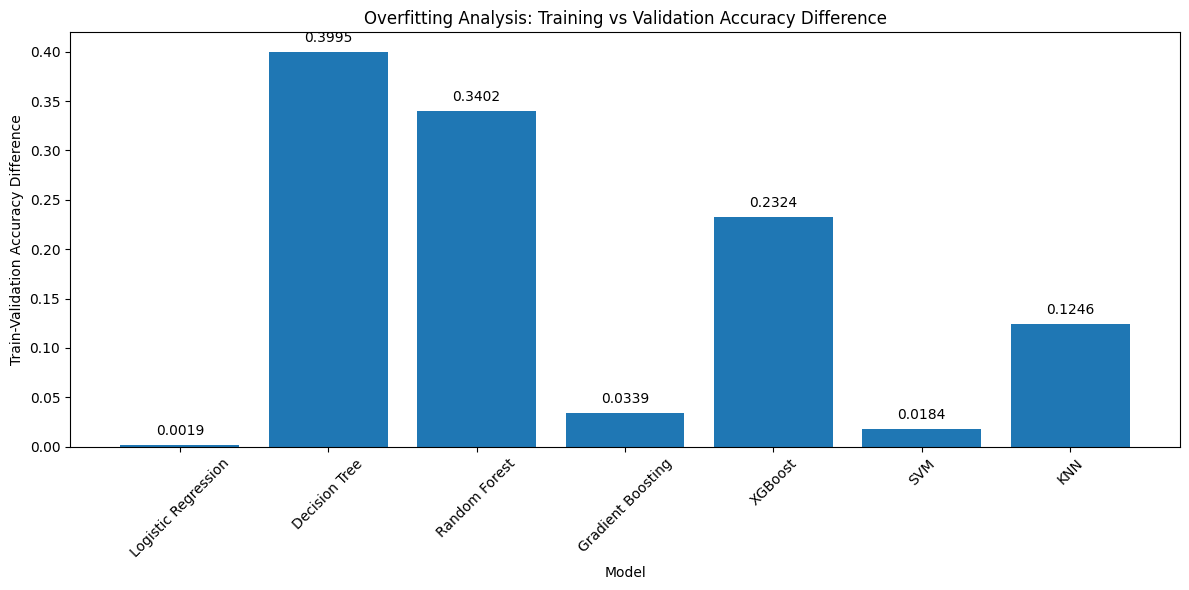


Best model is Gradient Boosting with validation accuracy 0.6673
Training accuracy for this model: 0.7011
Potential overfitting: 0.0339


In [31]:
# Calculate overfitting scores (difference between train and validation accuracy)
overfitting_scores = {model: train_results[model] - val_results[model] for model in model_names}

# Plot overfitting scores
plt.figure(figsize=(12, 6))
plt.bar(overfitting_scores.keys(), overfitting_scores.values())
plt.title('Overfitting Analysis: Training vs Validation Accuracy Difference')
plt.xlabel('Model')
plt.ylabel('Train-Validation Accuracy Difference')
plt.xticks(rotation=45)
for i, (k, v) in enumerate(overfitting_scores.items()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

# Determine the best model based on validation accuracy
best_model_name = max(val_results, key=val_results.get)
best_val_accuracy = val_results[best_model_name]
print(f"\nBest model is {best_model_name} with validation accuracy {best_val_accuracy:.4f}")
print(f"Training accuracy for this model: {train_results[best_model_name]:.4f}")
print(f"Potential overfitting: {overfitting_scores[best_model_name]:.4f}")


In [33]:
# 6. Optimize the best model using GridSearchCV
# We'll optimize the best model based on validation accuracy
best_model = models[best_model_name]

# Define hyperparameters for tuning based on model type
if best_model_name == "Logistic Regression":
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'newton-cg']
    }
elif best_model_name == "Decision Tree":
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "Random Forest":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == "Gradient Boosting":
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
elif best_model_name == "XGBoost":  # Added XGBoost hyperparameters
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
elif best_model_name == "SVM":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
elif best_model_name == "KNN":
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1 for manhattan_distance, 2 for euclidean_distance
    }

print(f"\nOptimizing {best_model_name} model using GridSearchCV...")

# Implement GridSearchCV with cross-validation on the training data
grid_search = GridSearchCV(
    best_model, param_grid, cv=5,
    scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Display best parameters and results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")




Optimizing Gradient Boosting model using GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation accuracy: 0.6749


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation accuracy: 0.6749

Tuned model accuracy on validation data: 0.6678

Validation Classification Report for tuned model:
              precision    recall  f1-score   support

           0       0.59      0.36      0.45      1456
           1       0.69      0.85      0.76      2451

    accuracy                           0.67      3907
   macro avg       0.64      0.61      0.60      3907
weighted avg       0.65      0.67      0.64      3907



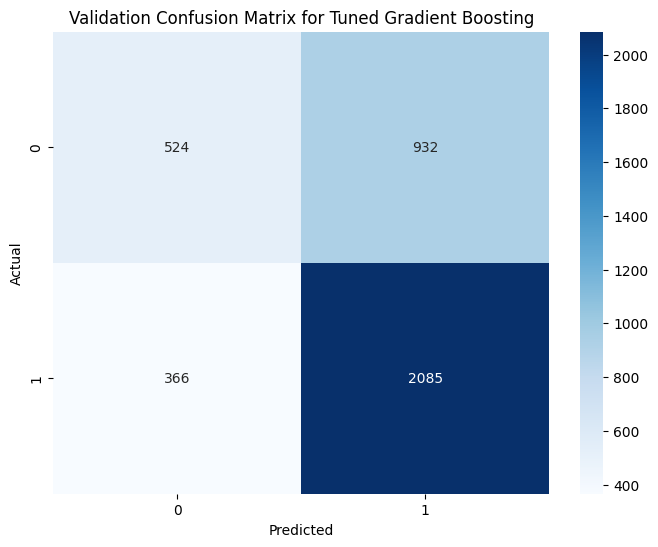

In [34]:
# Implement GridSearchCV with cross-validation on the training data
grid_search = GridSearchCV(
    best_model, param_grid, cv=5,
    scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Display best parameters and results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model from grid search
best_model_tuned = grid_search.best_estimator_

# Evaluate the tuned model on validation data
y_val_pred_tuned = best_model_tuned.predict(X_val_scaled)
val_tuned_accuracy = accuracy_score(y_val, y_val_pred_tuned)

print(f"\nTuned model accuracy on validation data: {val_tuned_accuracy:.4f}")
print("\nValidation Classification Report for tuned model:")
print(classification_report(y_val, y_val_pred_tuned))

# Plot confusion matrix for the tuned model on validation data
plt.figure(figsize=(8, 6))
cm_val_tuned = confusion_matrix(y_val, y_val_pred_tuned)
sns.heatmap(cm_val_tuned, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Confusion Matrix for Tuned {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




Tuned model accuracy on test data: 0.6619

Test Classification Report for tuned model:
              precision    recall  f1-score   support

           0       0.58      0.34      0.43      1459
           1       0.68      0.85      0.76      2448

    accuracy                           0.66      3907
   macro avg       0.63      0.60      0.59      3907
weighted avg       0.65      0.66      0.64      3907



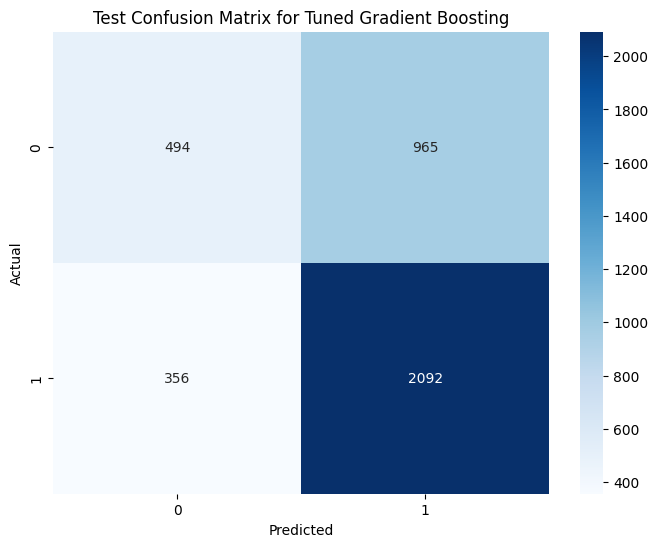


Performance comparison for tuned Gradient Boosting:
Validation accuracy: 0.6678
Test accuracy: 0.6619
Difference: 0.0059
The model generalizes well from validation to test data.


In [35]:
# Now evaluate the tuned model on the test set (final evaluation)
y_test_pred_tuned = best_model_tuned.predict(X_test_scaled)
test_tuned_accuracy = accuracy_score(y_test, y_test_pred_tuned)

print(f"\nTuned model accuracy on test data: {test_tuned_accuracy:.4f}")
print("\nTest Classification Report for tuned model:")
print(classification_report(y_test, y_test_pred_tuned))

# Plot confusion matrix for the tuned model on test data
plt.figure(figsize=(8, 6))
cm_test_tuned = confusion_matrix(y_test, y_test_pred_tuned)
sns.heatmap(cm_test_tuned, annot=True, fmt='d', cmap='Blues')
plt.title(f'Test Confusion Matrix for Tuned {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Compare validation and test performance
print(f"\nPerformance comparison for tuned {best_model_name}:")
print(f"Validation accuracy: {val_tuned_accuracy:.4f}")
print(f"Test accuracy: {test_tuned_accuracy:.4f}")
print(f"Difference: {abs(val_tuned_accuracy - test_tuned_accuracy):.4f}")

# If test performance is significantly worse than validation, the model might not generalize well
if test_tuned_accuracy < val_tuned_accuracy - 0.05:
    print("Warning: Test performance is noticeably worse than validation. The model may not generalize well.")
elif test_tuned_accuracy > val_tuned_accuracy + 0.05:
    print("Note: Test performance is better than validation. This could be a lucky test set split.")
else:
    print("The model generalizes well from validation to test data.")

In [36]:
# 7. Evaluate the final model using cross-validation on the entire dataset
print("\nEvaluating final model with cross-validation on the entire dataset...")
cv_scores = cross_val_score(best_model_tuned, X, y, cv=10, scoring='accuracy')
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f}")
print(f"Cross-validation accuracy standard deviation: {cv_scores.std():.4f}")



Evaluating final model with cross-validation on the entire dataset...
Cross-validation mean accuracy: 0.6697
Cross-validation accuracy standard deviation: 0.0082


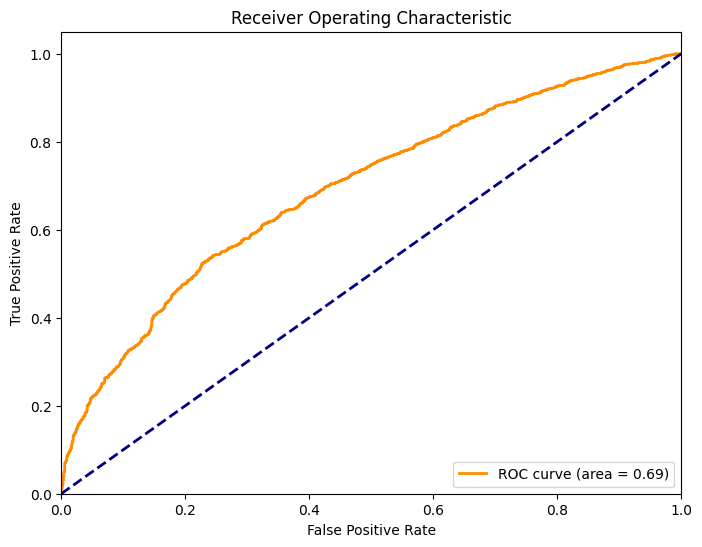

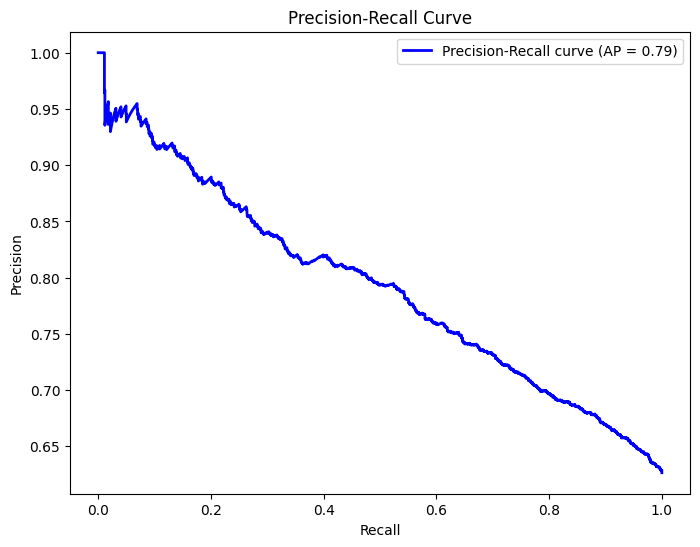

AUC-ROC: 0.6929
Average Precision: 0.7918


In [37]:
# 8. Advanced evaluation metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Evaluate on test data for multi-class or binary classification
if len(np.unique(y)) == 2:  # Binary classification
    # ROC curve and AUC
    y_test_proba = best_model_tuned.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    avg_precision = average_precision_score(y_test, y_test_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

    print(f"AUC-ROC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
else:  # Multi-class classification
    print("Multi-class classification detected - advanced evaluation metrics would require one-vs-rest or one-vs-one approach")


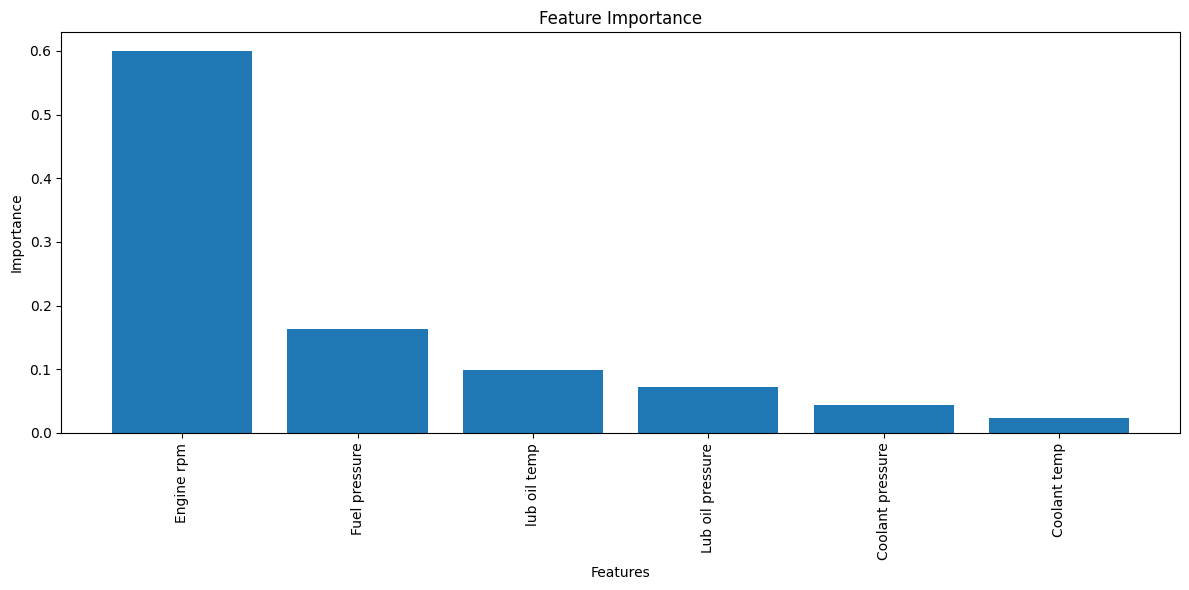


Feature Importance:
Engine rpm: 0.5992
Fuel pressure: 0.1632
lub oil temp: 0.0983
Lub oil pressure: 0.0719
Coolant pressure: 0.0435
Coolant temp: 0.0239


In [38]:
# 9. Display feature importances (for models that support this feature)
if best_model_name in ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:  # Added XGBoost to this list
    feature_importances = best_model_tuned.feature_importances_
    feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]

    # Sort features by importance
    sorted_indices = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_indices])
    plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=90)
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    print("\nFeature Importance:")
    for i in sorted_indices:
        print(f"{feature_names[i]}: {feature_importances[i]:.4f}")




Generating learning curve to check for overfitting/underfitting...


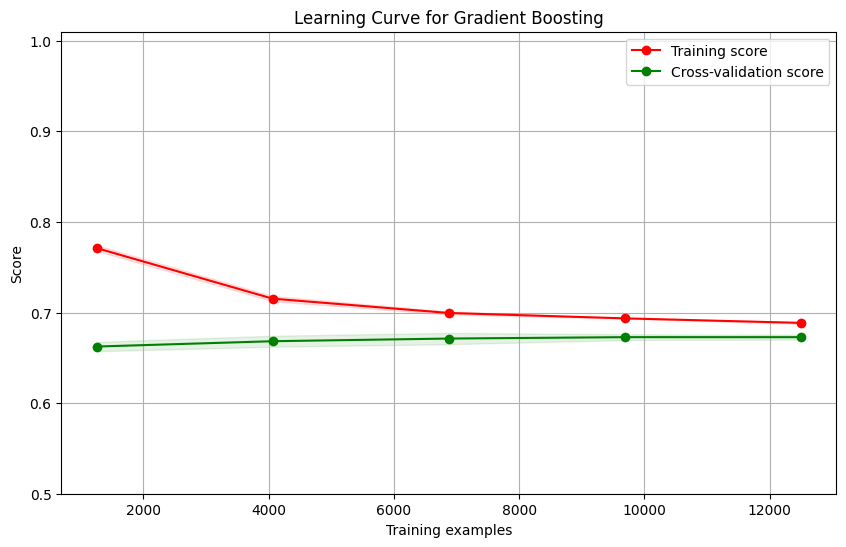


FINAL MODEL PERFORMANCE SUMMARY
Best Model: Gradient Boosting
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Training Accuracy: 0.6905
Validation Accuracy: 0.6678
Test Accuracy: 0.6619
Cross-Validation Accuracy: 0.6697 ± 0.0082

MODEL INTERPRETATION
------------------------------
Top 5 Most Important Features:
         Feature  Importance
      Engine rpm    0.599180
   Fuel pressure    0.163165
    lub oil temp    0.098336
Lub oil pressure    0.071872
Coolant pressure    0.043538
------------------------------


In [39]:
# 10. Learning Curves (to check for overfitting/underfitting)
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve for the best model
print("\nGenerating learning curve to check for overfitting/underfitting...")
# Combine all data for learning curve
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.concatenate((y_train, y_val))
plot_learning_curve(best_model_tuned, f"Learning Curve for {best_model_name}",
                    X_combined, y_combined, ylim=(0.5, 1.01), cv=5)
plt.show()

# Final Model Performance Summary
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Training Accuracy: {accuracy_score(y_train, best_model_tuned.predict(X_train_scaled)):.4f}")
print(f"Validation Accuracy: {val_tuned_accuracy:.4f}")
print(f"Test Accuracy: {test_tuned_accuracy:.4f}")
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print("="*50)

# Model Interpretation (if applicable)
if best_model_name in ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:
    print("\nMODEL INTERPRETATION")
    print("-"*30)
    print("Top 5 Most Important Features:")
    feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model_tuned.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(feature_importance.head(5).to_string(index=False))
    print("-"*30)